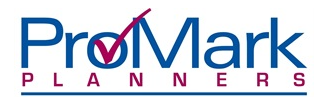

## Stock Analysis

Using a Rest API called Finnhubb, I have created code to be able to analyze specific stocks and compare them with one another. This allows me to evaluate different investment strategies in an effort to improve investment strategies at ProMark Planners. Here I work as a Financial Analyst working on improving client portfolios and conducting analysis to make recommendations on different holdings to clients. 

This code here was built to be able to compare different stocks against one another in a quick format. Tools such as Morningstar are rather clunky when it comes to comparing multiple stocks at once. This code will continue to adapt over time.

In [4]:
#load in libraries 
import pandas as pd
import finnhub
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
#intialize rest api
finnhub_client = finnhub.Client(api_key='btvl2lf48v6uc2r6ma9g')

In [6]:
#Save all the company's along with their display symbol/ticker to a dataframe title ticker

tickers = pd.DataFrame(finnhub_client.stock_symbols('US'))

In [7]:
#saving all the stock symbols for quick reference in different loops later

stock_sym = tickers['displaySymbol']

In [65]:
#use this to confirm if specific stocks are included in our api (I believe Finnhubb's free API only gives us US based companies)
stock_sym[stock_sym == 'HUBS']

4027    HUBS
Name: displaySymbol, dtype: object

## Created Functions

Build functions to be able to clean our dataframes and convert between unix and standard date and time. I also added a function to rename columns in the dataset for readability.

In [9]:
#function to convert normal calendar time to unix time for use with crypto_candles
def UNIX_cov(year, month, day):
    d = datetime.date(year, month, day)
    unix = time.mktime(d.timetuple())
    return int(unix)

#function to convert unix time to a normal date/time
def unix_to_date(unix):
    x = datetime.datetime.fromtimestamp(unix)
    return x

#price clean applies the unix to date function to a dataframe and saves the dates to a new column labeled timestamp
#renames columns so they are easier to understand
def price_clean(df):
    df['TimeStamp'] = df['t'].apply(unix_to_date)
    df.rename(columns={'c': 'close_price', 'h': 'high_price',
                'l': 'low_price', 'o': 'open_price', 's': 'status',
                't': 'unix_time', 'v': 'volume'}, inplace=True)
    df.drop('unix_time', axis=1, inplace=True)
    return df

## Load In Data

By specifying dates and stocks we will create a dataframe to house all open and closing prices between the start and end date. This will be used to evaluate the strength of different stocks when compared to one another or assist with the selection process between multiple different stocks.

In [10]:
#define start and end date that we want to return stock prices for 
#these dates are used in the function stock_candles which returns stock prices for specific dates within this region.

start_yr = 2019
start_mo = 11
start_day = 9
end_yr = 2020
end_mo = 11
end_day = 9

candles_start = UNIX_cov(start_yr, start_mo, start_day)
candles_end = UNIX_cov(end_yr, end_mo, end_day)

In [ ]:
#Create a list of stock values you want to compare.
stock_lst = ['BUD', 'PFE', 'ALGN', 'HUBS', 'ROP']

combined_df = pd.DataFrame()

#create a dataframe that stores daily stock performance for each stock into one combined dataframe
for i in range(len(stock_lst)):
    data = pd.DataFrame(finnhub_client.stock_candles(symbol=stock_lst[i], resolution='D', 
                                         _from=candles_start, to=candles_end))
    data['Ticker'] = stock_lst[i]
    data['pct_returns'] = 0
    for a in data.index:
        if a == 0:
            continue
        else:
            data['pct_returns'].loc[a] = round(((data['c'].loc[a] - data['c'].loc[a-1])/data['c'].loc[a-1])*100, 4)
    combined_df = pd.concat([combined_df, data])

combined_df = price_clean(combined_df)

In [61]:
#We now have stock price information for each day in the specified timeframe for all stocks we requested
combined_df

,close_price,high_price,low_price,open_price,status,volume,Ticker,pct_returns,TimeStamp
0,77.093500,77.283500,76.603500,76.693500,ok,722800,BUD,0.0000,2019-11-10 18:00:00
1,77.455900,78.215900,77.295900,78.135900,ok,1099700,BUD,0.4701,2019-11-11 18:00:00
2,77.651800,78.621800,77.471800,78.621800,ok,1977200,BUD,0.2529,2019-11-12 18:00:00
3,77.485300,78.155300,77.205300,77.895200,ok,1948000,BUD,-0.2144,2019-11-13 18:00:00
4,78.014200,78.164200,77.384200,77.434200,ok,748300,BUD,0.6826,2019-11-14 18:00:00
...,...,...,...,...,...,...,...,...,...
247,383.350006,390.678711,380.549988,385.730011,ok,623440,ROP,0.6326,2020-11-02 18:00:00
248,388.750000,397.549988,381.269989,386.869995,ok,733383,ROP,1.4086,2020-11-03 18:00:00
249,386.000000,398.410004,385.619995,398.410004,ok,689536,ROP,-0.7074,2020-11-04 18:00:00
250,388.420013,391.598907,384.160004,385.239990,ok,646094,ROP,0.6269,2020-11-05 18:00:00


## Analyze results

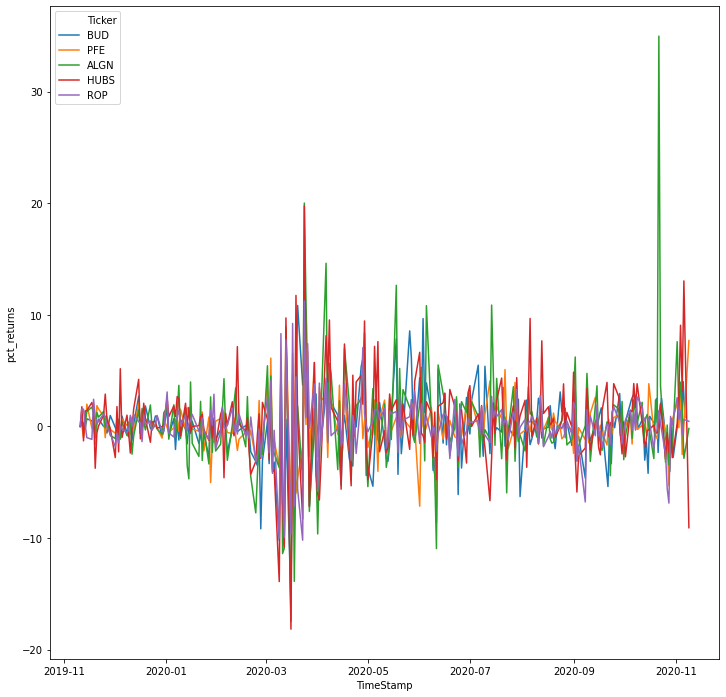

In [62]:
#print performance of each stock by its daily return
plt.figure(figsize=(12,12))
sns.lineplot(x='TimeStamp', y='pct_returns', data=combined_df, hue='Ticker')

#need way to change style or color of russell line

In [63]:
#Print out the average return over the time period specified in the model for each stock ticker
#difficult to see from our graphic above
avg_return = {}

for i in range(len(stock_lst)):
    avg_return[stock_lst[i]] = combined_df[combined_df['Ticker'] == stock_lst[i]]['pct_returns'].mean()

avg_return

{'BUD': -0.07486852589641455,
 'PFE': 0.0472646825396825,
 'ALGN': 0.3384801587301587,
 'HUBS': 0.42918928571428566,
 'ROP': 0.08969960317460329}

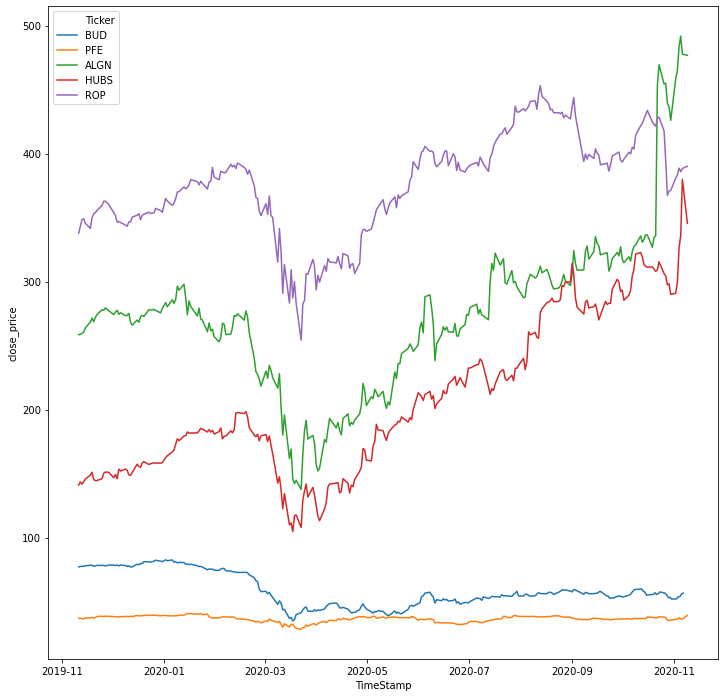

In [64]:
#print performance of each stock by closing price
plt.figure(figsize=(12,12))
sns.lineplot(x='TimeStamp', y='close_price', data=combined_df, hue='Ticker')

In [47]:
#Returns technical analysis of any stock symbol. Enter symbol in to view whether it is viewed as a buy, hold, or sell

import requests
symbol = 'LIT'
token = 'btvl2lf48v6uc2r6ma9g'
url = 'https://finnhub.io/api/v1/scan/technical-indicator?symbol={symbol}&resolution=D&token={token}'.format(symbol=symbol, token=token)
r = requests.get(url)
print(r.json())

{'technicalAnalysis': {'count': {'buy': 9, 'neutral': 8, 'sell': 0}, 'signal': 'buy'}, 'trend': {'adx': 36.15473528208604, 'trending': True}}


In [25]:
#Returns Basic Financials about a company
#Appears to only work for individual stocks and not ETFS, mutual funds, etc.
symbol = 'AAPL'
token = 'btvl2lf48v6uc2r6ma9g'
url = 'https://finnhub.io/api/v1/stock/metric?symbol={symbol}&metric=all&token={token}'.format(symbol=symbol, token=token)
r = requests.get(url)
r.json()['metric']

{'10DayAverageTradingVolume': 126.24544,
 '13WeekPriceReturnDaily': 4.50166,
 '26WeekPriceReturnDaily': 56.75249,
 '3MonthAverageTradingVolume': 3514.0679,
 '52WeekHigh': 137.98,
 '52WeekHighDate': '2020-09-02',
 '52WeekLow': 53.1525,
 '52WeekLowDate': '2020-03-23',
 '52WeekPriceReturnDaily': 85.08786,
 '5DayPriceReturnDaily': 3.21713,
 'assetTurnoverAnnual': 0.82884,
 'assetTurnoverTTM': 0.82884,
 'beta': 1.34172,
 'bookValuePerShareAnnual': 3.84873,
 'bookValuePerShareQuarterly': 3.84873,
 'bookValueShareGrowth5Y': -6.37004,
 'capitalSpendingGrowth5Y': -8.64702,
 'cashFlowPerShareAnnual': 3.9061,
 'cashFlowPerShareTTM': 3.9061,
 'cashPerSharePerShareAnnual': 5.35691,
 'cashPerSharePerShareQuarterly': 5.35691,
 'currentDividendYieldTTM': 0.6679,
 'currentEv/freeCashFlowAnnual': 43.45813,
 'currentEv/freeCashFlowTTM': 43.45813,
 'currentRatioAnnual': 1.3636,
 'currentRatioQuarterly': 1.3636,
 'dividendGrowthRate5Y': 9.83445,
 'dividendPerShare5Y': 0.674,
 'dividendPerShareAnnual': 0.79